### For nsa_z001_002 sample

In [16]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import statmorph

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data


import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord

In [18]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)

'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG'

In [19]:
lsbg_cat = Table.read('./Catalog/NSA/z001_002/nsa_cutout_cat_z001_002.fits')
print(len(lsbg_cat))
lsbg_cat.sort('viz-id')

2791


### The measurement is done by running `sbatch 1k_meas.slurm`, etc. Check `vanilla_measure_all.py` for details.

The measurement catalogs are saved at `./Catalog/NSA/z002_004/lsbg_measure_vaniila_XXXXX.fits`.

Below, we combine these catalogs together.

In [20]:
import sys
sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')

In [21]:
from tqdm import trange

In [23]:
suffix = 'nosegmap'
meas_cat_all = vstack([Table.read(f'./Catalog/nsa_z001_002/vanilla/_lsbg_meas_vanilla_vanilla_0_1000_{suffix}.fits'),
                       Table.read(f'./Catalog/nsa_z001_002/vanilla/_lsbg_meas_vanilla_vanilla_1000_2000_{suffix}.fits'),
                       Table.read(f'./Catalog/nsa_z001_002/vanilla/_lsbg_meas_vanilla_vanilla_2000_2791_{suffix}.fits')
                      ])
meas_cat_all.write(f'./Catalog/nsa_z001_002/vanilla/lsbg_meas_vanilla_{suffix}_all.fits', overwrite=True)
failed_meas_ind = lsbg_cat[(np.isnan(meas_cat_all['rhalf_circularized']))]['viz-id'].data
len(failed_meas_ind)

4

In [24]:
suffix = 'segmap'
meas_cat_all = vstack([Table.read(f'./Catalog/nsa_z001_002/vanilla/_lsbg_meas_vanilla_vanilla_0_1000_{suffix}.fits'),
                       Table.read(f'./Catalog/nsa_z001_002/vanilla/_lsbg_meas_vanilla_vanilla_1000_2000_{suffix}.fits'),
                       Table.read(f'./Catalog/nsa_z001_002/vanilla/_lsbg_meas_vanilla_vanilla_2000_2791_{suffix}.fits')
                      ])
meas_cat_all.write(f'./Catalog/nsa_z001_002/vanilla/lsbg_meas_vanilla_{suffix}_all.fits', overwrite=True)
failed_meas_ind = lsbg_cat[(np.isnan(meas_cat_all['rhalf_circularized']))]['viz-id'].data
len(failed_meas_ind)

114

In [78]:
from kuaizi.measure import makeMeasurement

[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>,
 <AxesSubplot:title={'center':'log-Likelihood'}, xlabel='Iteration'>]

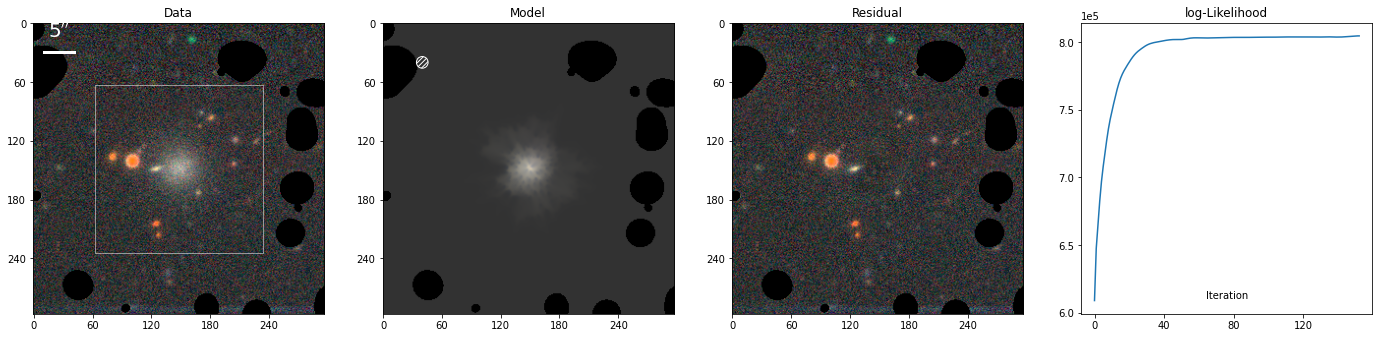

In [13]:
ind = 35129
method = 'vanilla'
# method = 'vanilla'
with open(f'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Model/nsa_z002_004/vanilla/nsa-{ind}-trained-model-{method}.df', "rb") as fp:
    blend, info, mask = dill.load(fp)
    fp.close()
    
kz.display.display_scarlet_model(
    blend,
    show_ind=[0],
    zoomin_size=50,
    minimum=-0.2,
    stretch=1,
    add_boxes=True,
    channels='griz',
    show_mask=True,
    show_mark=False, 
    show_loss=True)

### Analysis: make cuts to rule out junks

In [25]:
import kuaizi
from kuaizi.display import plot_measurement
import pickle
from astropy.cosmology import Planck15
cosmos = Planck15
h = cosmos.h
kuaizi.set_matplotlib(style='nature', usetex=False)

In [27]:
method = 'vanilla'

In [28]:
meas_cat = Table.read(f'./Catalog/nsa_z001_002/vanilla/lsbg_meas_{method}_nosegmap_all.fits')
seg_meas_cat = Table.read(f'./Catalog/nsa_z001_002/vanilla/lsbg_meas_{method}_segmap_all.fits')
# old_meas_cat = Table.read('/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Catalog/NSA/z002_004/lsbg_measure_vanilla_all.fits')

In [29]:
junk = (lsbg_cat['bad_votes'] > lsbg_cat['good_votes'])
candy = (lsbg_cat['good_votes'] > lsbg_cat['bad_votes']) & (lsbg_cat['is_candy'] > lsbg_cat['is_galaxy'])
gal = (~junk) & (~candy)

(19.0, 29.0)

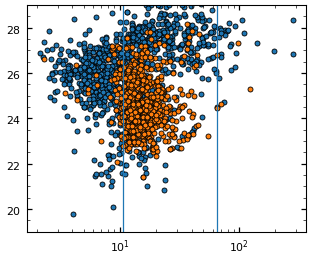

In [30]:
plt.scatter(meas_cat['rhalf_circularized'][junk], meas_cat['SB_eff_avg'][:, 0][junk])
plt.scatter(meas_cat['rhalf_circularized'][candy], meas_cat['SB_eff_avg'][:, 0][candy])

plt.axvline(1.8 / 0.168)
plt.axvline(11 / 0.168)
plt.xscale('log')
plt.ylim(19, 29)

(19.0, 29.0)

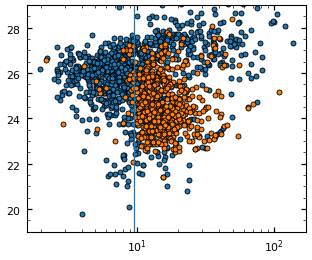

In [31]:
plt.scatter(seg_meas_cat['rhalf_circularized'][junk], seg_meas_cat['SB_eff_avg'][:, 0][junk])
plt.scatter(seg_meas_cat['rhalf_circularized'][candy], seg_meas_cat['SB_eff_avg'][:, 0][candy])

plt.axvline(1.6 / 0.168)
plt.xscale('log')
plt.ylim(19, 29)

# of Candy: 631
# of Gal: 1229
# of Junk: 931


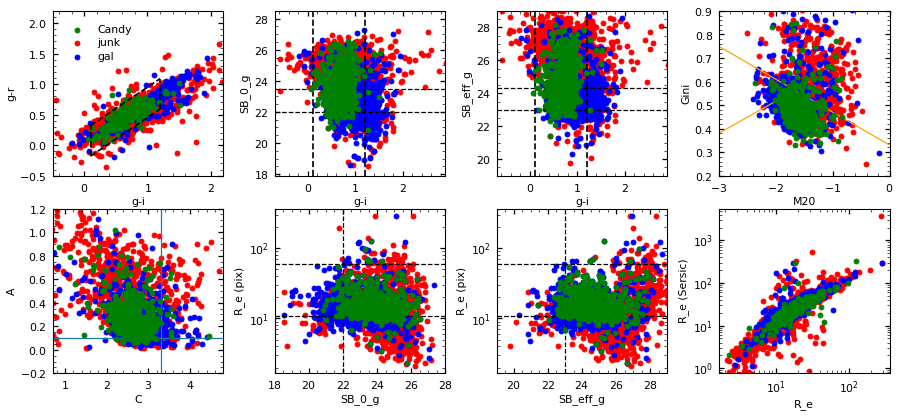

In [32]:
plot_measurement(lsbg_cat, meas_cat)

# of Candy: 631
# of Gal: 1229
# of Junk: 931


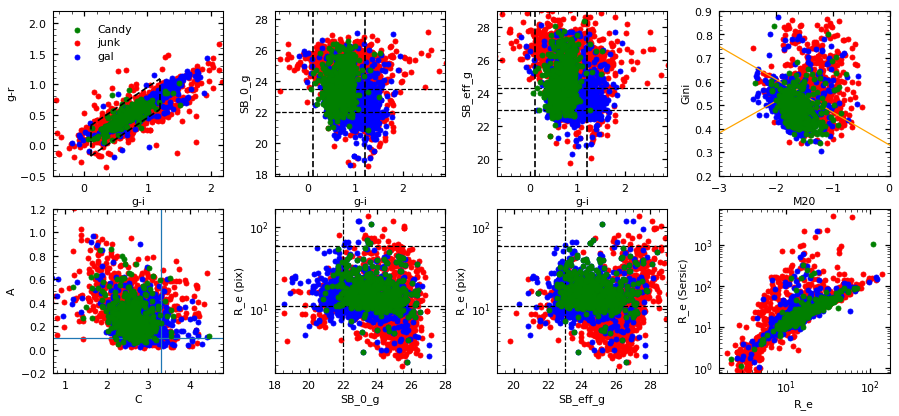

In [33]:
plot_measurement(lsbg_cat, seg_meas_cat)

In [34]:
g_mag = meas_cat['mag'].data[:, 0]
r_mag = meas_cat['mag'].data[:, 1]
i_mag = meas_cat['mag'].data[:, 2]

In [37]:
color_bound = [0.1, 1.2]
half_width = 0.25

# Color cuts
mask = (g_mag - i_mag < color_bound[1]) & (g_mag - i_mag > color_bound[0]) & (
    (g_mag - r_mag) > 0.7 * (g_mag - i_mag) - half_width) & (
    (g_mag - r_mag) < 0.7 * (g_mag - i_mag) + half_width) & (i_mag < 22.5)

# Size cuts
min_size = 1.8
max_size = 12
mask &= (meas_cat['rhalf_circularized'] >= min_size /
         0.168) & (meas_cat['rhalf_circularized'] <= max_size / 0.168)

# SB cuts
min_cen_SB = 22.
min_eff_SB = 23.0
mask &= (meas_cat['SB_0'][:, 0] > 22.0)
mask &= (meas_cat['SB_eff_avg'][:, 0] > 23.0)  # Cuts based on JG votes

# Shape cuts
mask &= (meas_cat['ell_sym'] < 0.65)

mask &= (meas_cat['M20'] < -1.1)
mask &= (meas_cat['Gini'] < 0.7)
mask &= ~((meas_cat['M20'] < -1.6) & (
    meas_cat['Gini'] > meas_cat['M20'] * 0.136 + 0.788) & (meas_cat['Gini'] < meas_cat['M20'] * -0.136 + 0.33))
mask &= (meas_cat['Gini'] < meas_cat['M20'] * -0.136 + 0.37)

mask &= (meas_cat['C'] < 3.5) & (meas_cat['C'] > 1.8)
#mask &= (meas_cat['A_outer'] <= 0.13)
mask &= (meas_cat['A'] < 0.7)

# mask &= (seg_meas_cat['rhalf_circularized'] > 1.8 / 0.168) & (seg_meas_cat['rhalf_circularized'] < 12 / 0.168)

print('Candy:', np.sum(mask & candy))
print('Gal:', np.sum(mask & gal))
print('Junk:', np.sum(mask & junk))

Candy: 454
Gal: 428
Junk: 45


# of Candy: 454
# of Gal: 428
# of Junk: 45


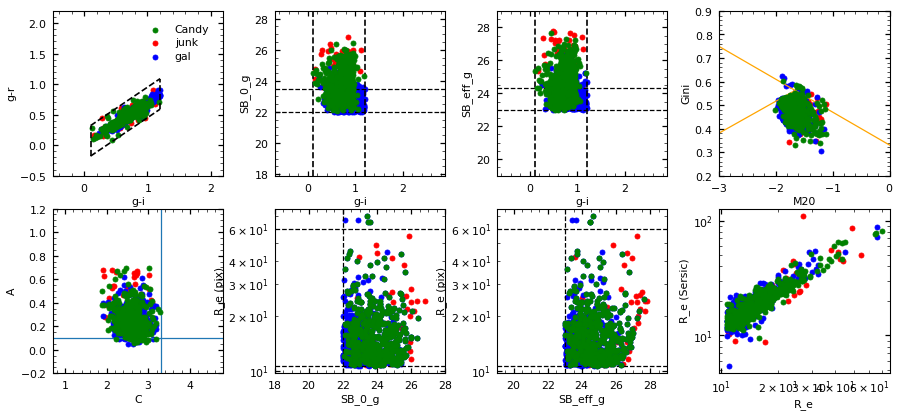

In [38]:
plot_measurement(lsbg_cat[mask], meas_cat[mask])

In [39]:
# Save this mask
np.save('./Catalog/nsa_z001_002/lsbg_cuts_mask_vanilla.npy', mask)

### Visual inspection using `galary`

In [216]:

# hstack([lsbg_cat[mask], meas_cat[mask]]
#       ).write('./Catalog/nsa_z002_004/lsbg_NSA_MW_z002_004_after_cuts_vanilla.fits', overwrite=True)

### Load Spergel catalog, apply mask, plot properties

In [48]:
suffix = 'nosegmap'
meas_cat_all = vstack([Table.read(f'./Catalog/nsa_z001_002/spergel/_lsbg_meas_spergel_spergel_0_1000_{suffix}.fits'),
                       Table.read(f'./Catalog/nsa_z001_002/spergel/_lsbg_meas_spergel_spergel_1000_2000_{suffix}.fits'),
                       Table.read(f'./Catalog/nsa_z001_002/spergel/_lsbg_meas_spergel_spergel_2000_2791_{suffix}.fits'),
                      ])
meas_cat_all.write(f'./Catalog/nsa_z001_002/spergel/lsbg_meas_spergel_{suffix}_all.fits', overwrite=True)
failed_meas_ind = lsbg_cat[(np.isnan(meas_cat_all['rhalf_spergel']))]['viz-id'].data
len(failed_meas_ind)

1

In [49]:
meas_cat = Table.read(f'./Catalog/nsa_z001_002/spergel/lsbg_meas_spergel_nosegmap_all.fits')
mask = np.load('./Catalog/nsa_z001_002/lsbg_cuts_mask_vanilla.npy')
cuts_cat = hstack([lsbg_cat[mask], meas_cat[mask]])

Text(0.5, 0, '$d_{ang} / R_{vir, ang}$')

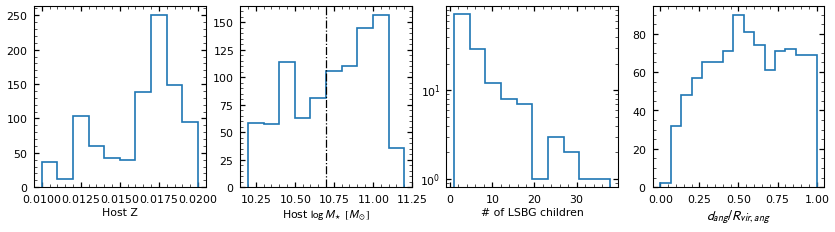

In [54]:
fig, axes = plt.subplots(1, 4, figsize=(17, 4))

plt.sca(axes[0])
plt.hist(cuts_cat['host_z'], range=[0.01, 0.02], 
         bins=10, histtype='step', lw=2);
plt.xlabel('Host Z')

plt.sca(axes[1])
plt.hist(cuts_cat['host_stellar_mass'], range=[10.2, 11.2], 
         bins=10, histtype='step', lw=2);
plt.xlabel(r'Host $\log\, M_\star\ [M_\odot]$')
plt.axvline(10.7, c='k', ls='-.')
plt.subplots_adjust(wspace=0.2)

plt.sca(axes[2])
uniques, counts = np.unique(cuts_cat['host_name'], return_counts=True)
plt.hist(counts, histtype='step', lw=2)
plt.yscale('log')
plt.xlabel('# of LSBG children')

plt.sca(axes[3])
lsbg_coord = SkyCoord(cuts_cat['ra'], cuts_cat['dec'], unit='deg')
host_coord = SkyCoord(cuts_cat['host_RA'], cuts_cat['host_DEC'], unit='deg')
dist = lsbg_coord.separation(host_coord)
plt.hist(dist.to(u.deg).value / cuts_cat['host_r_vir_ang'].data, 
         range=[0, 1.], bins=15, histtype='step', lw=2);
plt.xlabel(r'$d_{ang} / R_{vir, ang}$', fontsize=17)

In [221]:
# cuts_cat = hstack([cuts_cat[cuts_cat.colnames[:51]], meas_cat[np.in1d(meas_cat['ID'], cuts_cat['viz-id'])]])
# cuts_cat['mag_circ'] = -2.5 * np.log10(cuts_cat['flux_circ']) + 27.0

In [64]:
ang_diam_dist = cuts_cat['host_ang_diam_dist'] # not consider peculiar motion

rhalf_phys = cuts_cat['rhalf_spergel'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
cuts_cat['rhalf_circularized_phys'] = rhalf_phys

In [65]:
cuts_cat['abs_mag'] = cuts_cat['mag'] - 25 - 5 * np.log10(ang_diam_dist)[:, np.newaxis] # ugri
BV = 0.62 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) + 0.15
V = cuts_cat['mag'][:, 0] - 0.52 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) - 0.03
V_abs = V - 25 - 5 * np.log10(ang_diam_dist)
log_ML_V = 1.493 * BV - 0.681
M = (4.83 - V_abs) / (2.5) + log_ML_V
cuts_cat['log_m_star'] = M
cuts_cat['V_abs'] = V_abs

In [66]:
### UDGs
flag = (cuts_cat['rhalf_circularized_phys'] > 1.5) & (cuts_cat['SB_eff_avg'][:, 0] >= 23.)# & (cuts_cat['sersic_ell'] < 0.7)
print('# of UDGs:', np.sum(flag))

# of UDGs: 100


In [67]:
udg_cat = cuts_cat[flag]

In [68]:
junk = (udg_cat['bad_votes'] > udg_cat['good_votes'])
candy = (udg_cat['good_votes'] > udg_cat['bad_votes']) & (
    udg_cat['is_candy'] > udg_cat['is_galaxy'])
gal = (~junk) & (~candy)
print('# of Candy:', np.sum(candy))
print('# of Gal:', np.sum(gal))
print('# of Junk:', np.sum(junk))

# of Candy: 63
# of Gal: 17
# of Junk: 20


In [69]:
udg_cat[['viz-id', 'ra', 'dec']].write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_002/udg_z001_002_spergel.txt', 
    format='ascii')

### Then I vote

In [73]:
voted_cat = Table.read(
    '/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_002/lsbg_z001_002_SB_eff_23_votes.txt', format='ascii')

In [81]:
junk = (voted_cat['marked'].data == 'true')

In [85]:
udg_cat[~junk].write('/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_002/lsbg_z001_002_SBeff_23_voted.fits')

In [88]:
udg_cat[~junk][['viz-id', 'ra', 'dec']].write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_002/lsbg_z001_002_SBeff_23_voted_viz.txt', 
    format='ascii')

In [89]:
udg_cat[~junk]

ra,dec,a_image,b_image,theta_image,ellipticity,mag_auto_g,mag_auto_r,mag_auto_i,flux_radius_ave_g,flux_radius_ave_i,mu_ave_g,mu_ave_i,acorr_ratio,g-i,g-r,A_g,A_r,A_i,tract,patch,synth_id,viz-id,is_candy,is_galaxy,is_tidal,is_outskirts,is_cirrus,is_junk,num_votes,good_votes,bad_votes,host_name,host_z,host_ang_diam_dist,host_stellar_mass,host_halo_mass,host_r_vir,host_r_vir_ang,host_300kpc_ang,host_nvotes,host_spiral,host_elliptical,host_uncertain,host_RA,host_DEC,cutout_size,prefix,RA,DEC,radius,image_flag [5],psf_flag [5],ID,flux [4],mag [4],flux_circ [4],flux_ellip [4],SB_0 [4],SB_eff_circ [4],SB_eff_ellip [4],SB_eff_avg [4],xc_cen,yc_cen,xc_sym,yc_sym,ell_cen,ell_sym,PA_cen,PA_sym,rhalf_circ,rhalf_ellip,rhalf_circularized,rhalf_spergel,r20,r50,r80,Gini,M20,"F(G,M20)","S(G,M20)",C,A,A_outer,A_shape,S,sersic_n,sersic_rhalf,sersic_ell,sersic_PA,sersic_xc,sersic_yc,sersic_amp,flag,flag_sersic,rhalf_circularized_phys,abs_mag [4],log_m_star,V_abs
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,Mpc,,,,,,,,,,,,,,,,arcmin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,bytes3,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,bytes19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes66,float64,float64,float64,bool,bool,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
189.9153345,0.8239197,32.58,18.023,-88.03,0.447,19.189,18.6441,18.3684,6.9216,7.408044,24.876256584727937,24.204459723594407,1.1026736953397585,0.7321170864015475,0.5035824126347044,0.04467713370700853,0.03165954634171251,0.022594220108555194,9597,"2,4",-1,1984,2,0,0,0,0,0,2,2,0,J123911.40+004307.9,0.01695742830634117,73.50498082789666,10.29447206808053,11.770095825195312,218.8789435471297,0.17061210321967227,0.2338444719095634,33.0,1.0,0.0,0.0,189.79784591295413,0.7173774370899869,1.0,/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/z001_002/nsa_1984,189.9153345,0.8239197,1.0,True .. True,True .. True,1984,1569.1796620629002 .. 3572.9553975167046,19.010818323353284 .. 18.117431013043635,1444.032639251861 .. 3288.000945552921,1444.0326084805727 .. 3288.0008754880055,23.346168171075167 .. 22.452780860765518,25.964951804195405 .. 25.071564493885756,25.908927117628295 .. 25.015539807318646,25.138260295315625 .. 24.244872985005976,358.2049721308373,354.86999059810967,358.2792709683778,354.47424439158146,0.2825488441460854,0.2825766640815689,-1.5500504287543857,-1.5500223370806052,38.085381655734025,43.91892196228712,37.19969857557399,39.9106846969989,16.679213220089594,38.01227121264641,71.01226801041446,0.5322659184343442,-1.989470090363057,0.053419068871602526,-0.07659308331046422,3.145789114685133,0.008885403926220434,0.016491954426661584,0.401652308705423,0.006941788140182728,1.7357523580940102,54.122884273409014,0.4009304240975087,1.5862532605015727,358.21743147010926,354.4259999082694,0.06016698604940916,0.0,0.0,2.3894045575586276,-15.320765519875845 .. -16.214152830185494,8.219527810800287,-15.627939658049524
128.9691719,1.7430692,64.771,28.168,-48.36,0.565,19.3845,18.5892,17.9969,11.665752000000001,15.091104000000001,26.18514683653129,25.34277426697923,1.087206739097039,0.9353139547602722,0.6199915803405369,0.13147677362956056,0.09316835397009687,0.06649072838983344,9799,"6,1",-1,2098,0,0,1,0,1,0,2,0,2,J083548.50+014317.9,0.013682819902896881,59.54781815939559,10.67037424398385,12.231813430786133,312.5734169652713,0.3007522112147536,0.28865430797159136,nan,nan,nan,nan,128.95219061532282,1.7217679722089745,1.0,/scratch/gpfs/jiaxuanl/Dat

In [348]:
print('Total hosts:', len(np.unique(lsbg_cat['host_name'])))
print('Hosts for LSBGs after cuts:', len(np.unique(cuts_cat['host_name'])))
print('')
print('LSBGs after cuts:', len(cuts_cat))
print('UDGs:', len(udg_cat))
print('UDG hosts:', len(np.unique(udg_cat['host_name'])))

print('UDG fraction:', len(udg_cat) / len(np.unique(cuts_cat['host_name'])))
## SAGA UDG fraction: 1/6 = 0.167

Total hosts: 754
Hosts for LSBGs after cuts: 557

LSBGs after cuts: 1649
UDGs: 201
UDG hosts: 148
UDG fraction: 0.3608617594254937


In [250]:
print('Total hosts:', len(np.unique(lsbg_cat['host_name'])))
print('Hosts for LSBGs after cuts:', len(np.unique(cuts_cat['host_name'])))
print('')
print('LSBGs after cuts:', len(cuts_cat))
print('UDGs:', len(udg_cat))
print('UDG hosts:', len(np.unique(udg_cat['host_name'])))

print('UDG fraction:', len(udg_cat) / len(np.unique(cuts_cat['host_name'])))
## SAGA UDG fraction: 1/6 = 0.167

Total hosts: 754
Hosts for LSBGs after cuts: 585

LSBGs after cuts: 1996
UDGs: 317
UDG hosts: 210
UDG fraction: 0.5418803418803418


In [367]:
udg_cat.write('./Catalog/nsa_z002_004/UDG_NSA_MW_z002_004_new.fits', overwrite=True)

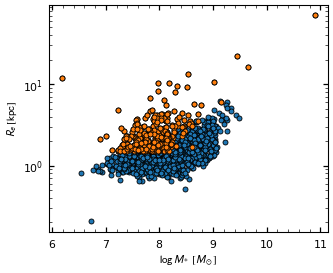

In [251]:
plt.scatter(cuts_cat['log_m_star'], cuts_cat['rhalf_circularized_phys'])
plt.scatter(udg_cat['log_m_star'], udg_cat['rhalf_circularized_phys'])

plt.xlabel(r'$\log\, M_*\ [M_\odot]$')
plt.ylabel(r'$R_e\ [\rm kpc]$')

plt.yscale('log')

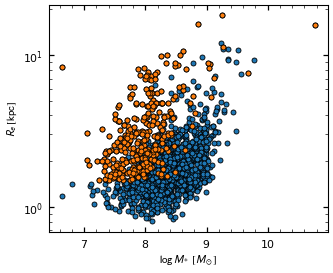

In [144]:
# old
plt.scatter(cuts_cat['log_m_star'], cuts_cat['rhalf_circularized_phys'])
plt.scatter(udg_cat['log_m_star'], udg_cat['rhalf_circularized_phys'])

plt.xlabel(r'$\log\, M_*\ [M_\odot]$')
plt.ylabel(r'$R_e\ [\rm kpc]$')

plt.yscale('log')

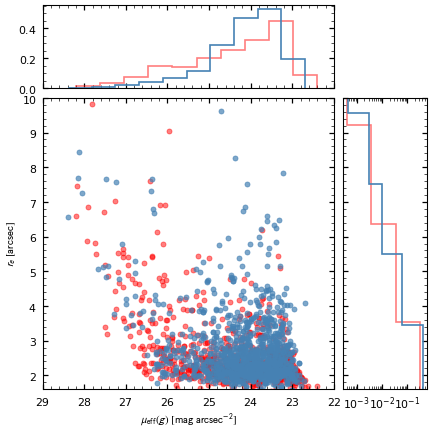

In [254]:
# start with a square Figure
fig = plt.figure(figsize=(8, 8))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)


red = ((cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 2]) > 0.8)

ax.scatter(cuts_cat[red]['SB_eff_avg'][:, 0], 
           cuts_cat[red]['rhalf_circularized'] * 0.168, 
           color='r', alpha=0.5)
ax.scatter(cuts_cat[~red]['SB_eff_avg'][:, 0], 
            cuts_cat[~red]['rhalf_circularized'] * 0.168,
            color='steelblue', alpha=0.7)
ax.set_xlim(29, 22)
ax.set_ylim(1.6, 10)
ax.set_xlabel(r'$\mu_{\rm eff}(g)\ [\rm mag\ arcsec^{-2}]$')
ax.set_ylabel(r'$r_e\ [\rm arcsec]$')

ax_histx.hist(cuts_cat[red]['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, color='r', alpha=0.5)
ax_histx.hist(cuts_cat[~red]['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, color='steelblue')
ax_histy.hist(cuts_cat[red]['rhalf_circularized'] * 0.168, lw=2,
              histtype='step', density=True, orientation='horizontal', color='r', alpha=0.5)
ax_histy.hist(cuts_cat[~red]['rhalf_circularized'] * 0.168, lw=2,
              histtype='step', density=True, orientation='horizontal', color='steelblue')
ax_histy.set_xscale('log')

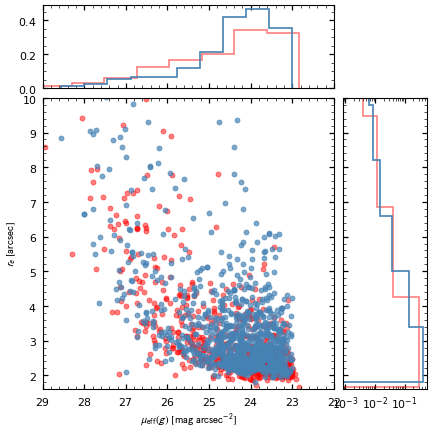

In [156]:
# start with a square Figure
# old
fig = plt.figure(figsize=(8, 8))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)


red = ((cuts_cat['mag_circ'][:, 0] - cuts_cat['mag_circ'][:, 2]) > 0.8)

ax.scatter(cuts_cat[red]['SB_eff_avg'][:, 0], 
           cuts_cat[red]['rhalf_circularized'] * 0.168, 
           color='r', alpha=0.5)
ax.scatter(cuts_cat[~red]['SB_eff_avg'][:, 0], 
            cuts_cat[~red]['rhalf_circularized'] * 0.168,
            color='steelblue', alpha=0.7)
ax.set_xlim(29, 22)
ax.set_ylim(1.6, 10)
ax.set_xlabel(r'$\mu_{\rm eff}(g)\ [\rm mag\ arcsec^{-2}]$')
ax.set_ylabel(r'$r_e\ [\rm arcsec]$')

ax_histx.hist(cuts_cat[red]['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, color='r', alpha=0.5)
ax_histx.hist(cuts_cat[~red]['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, color='steelblue')
ax_histy.hist(cuts_cat[red]['rhalf_circularized'] * 0.168, lw=2,
              histtype='step', density=True, orientation='horizontal', color='r', alpha=0.5)
ax_histy.hist(cuts_cat[~red]['rhalf_circularized'] * 0.168, lw=2,
              histtype='step', density=True, orientation='horizontal', color='steelblue')
ax_histy.set_xscale('log')

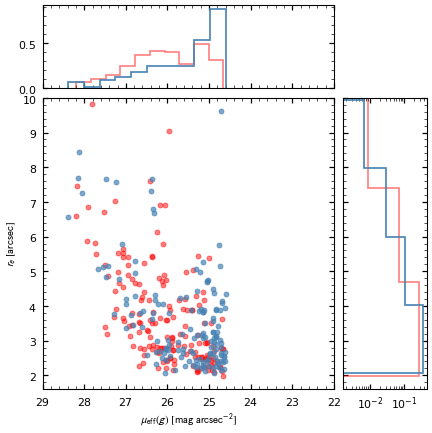

In [255]:
# start with a square Figure
fig = plt.figure(figsize=(8, 8))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)


red = ((udg_cat['mag'][:, 0] - udg_cat['mag'][:, 2]) > 0.8)

ax.scatter(udg_cat[red]['SB_eff_avg'][:, 0], 
           udg_cat[red]['rhalf_circularized'] * 0.168, 
           color='r', alpha=0.5)
ax.scatter(udg_cat[~red]['SB_eff_avg'][:, 0], 
            udg_cat[~red]['rhalf_circularized'] * 0.168,
            color='steelblue', alpha=0.7)
ax.set_xlim(29, 22)
ax.set_ylim(1.6, 10)
ax.set_xlabel(r'$\mu_{\rm eff}(g)\ [\rm mag\ arcsec^{-2}]$')
ax.set_ylabel(r'$r_e\ [\rm arcsec]$')

ax_histx.hist(udg_cat[red]['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, color='r', alpha=0.5)
ax_histx.hist(udg_cat[~red]['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, color='steelblue')
ax_histy.hist(udg_cat[red]['rhalf_circularized'] * 0.168, lw=2,
              histtype='step', density=True, orientation='horizontal', color='r', alpha=0.5)
ax_histy.hist(udg_cat[~red]['rhalf_circularized'] * 0.168, lw=2,
              histtype='step', density=True, orientation='horizontal', color='steelblue')
ax_histy.set_xscale('log')

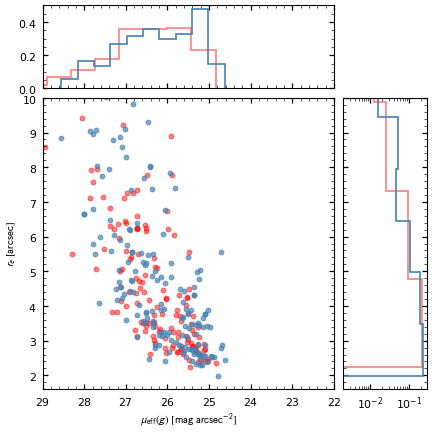

In [157]:
# start with a square Figure
# old 
fig = plt.figure(figsize=(8, 8))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)


red = ((udg_cat['mag_circ'][:, 0] - udg_cat['mag_circ'][:, 2]) > 0.8)

ax.scatter(udg_cat[red]['SB_eff_avg'][:, 0], 
           udg_cat[red]['rhalf_circularized'] * 0.168, 
           color='r', alpha=0.5)
ax.scatter(udg_cat[~red]['SB_eff_avg'][:, 0], 
            udg_cat[~red]['rhalf_circularized'] * 0.168,
            color='steelblue', alpha=0.7)
ax.set_xlim(29, 22)
ax.set_ylim(1.6, 10)
ax.set_xlabel(r'$\mu_{\rm eff}(g)\ [\rm mag\ arcsec^{-2}]$')
ax.set_ylabel(r'$r_e\ [\rm arcsec]$')

ax_histx.hist(udg_cat[red]['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, color='r', alpha=0.5)
ax_histx.hist(udg_cat[~red]['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, color='steelblue')
ax_histy.hist(udg_cat[red]['rhalf_circularized'] * 0.168, lw=2,
              histtype='step', density=True, orientation='horizontal', color='r', alpha=0.5)
ax_histy.hist(udg_cat[~red]['rhalf_circularized'] * 0.168, lw=2,
              histtype='step', density=True, orientation='horizontal', color='steelblue')
ax_histy.set_xscale('log')

Text(0.5, 0, '$d_{ang} / R_{vir, ang}$')

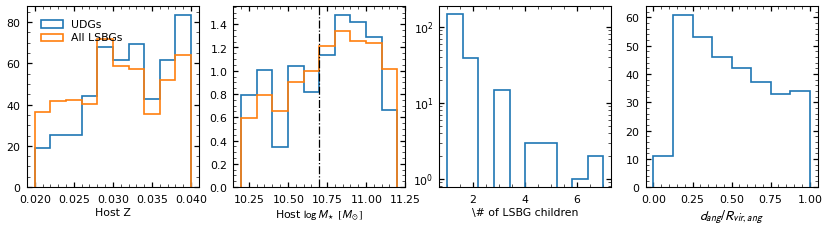

In [256]:
fig, axes = plt.subplots(1, 4, figsize=(17, 4))

plt.sca(axes[0])
plt.hist(udg_cat['host_z'], range=[0.02, 0.04], 
         bins=10, histtype='step', lw=2, density=True, label='UDGs');
plt.hist(cuts_cat['host_z'], range=[0.02, 0.04], 
         bins=10, histtype='step', lw=2, density=True, label='All LSBGs');
plt.xlabel('Host Z')
plt.legend(loc='upper left')

plt.sca(axes[1])
plt.hist(udg_cat['host_stellar_mass'], range=[10.2, 11.2], 
         bins=10, histtype='step', lw=2, density=True, label='UDGs');
plt.hist(cuts_cat['host_stellar_mass'], range=[10.2, 11.2], 
         bins=10, histtype='step', lw=2, density=True, label='All LSBGs');
plt.xlabel(r'Host $\log\, M_\star\ [M_\odot]$')
plt.axvline(10.7, c='k', ls='-.')
plt.subplots_adjust(wspace=0.2)

plt.sca(axes[2])
uniques, counts = np.unique(udg_cat['host_name'], return_counts=True)
plt.hist(counts, histtype='step', lw=2)
plt.yscale('log')
plt.xlabel('\# of LSBG children')

plt.sca(axes[3])
lsbg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = lsbg_coord.separation(host_coord)
plt.hist(dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data, 
         range=[0, 1.], bins=8, histtype='step', lw=2);
plt.xlabel(r'$d_{ang} / R_{vir, ang}$', fontsize=17)

Text(0.5, 0, '$d_{ang} / R_{vir, ang}$')

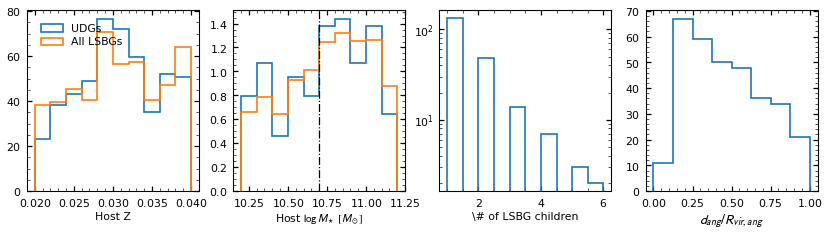

In [158]:
# old
fig, axes = plt.subplots(1, 4, figsize=(17, 4))

plt.sca(axes[0])
plt.hist(udg_cat['host_z'], range=[0.02, 0.04], 
         bins=10, histtype='step', lw=2, density=True, label='UDGs');
plt.hist(cuts_cat['host_z'], range=[0.02, 0.04], 
         bins=10, histtype='step', lw=2, density=True, label='All LSBGs');
plt.xlabel('Host Z')
plt.legend(loc='upper left')

plt.sca(axes[1])
plt.hist(udg_cat['host_stellar_mass'], range=[10.2, 11.2], 
         bins=10, histtype='step', lw=2, density=True, label='UDGs');
plt.hist(cuts_cat['host_stellar_mass'], range=[10.2, 11.2], 
         bins=10, histtype='step', lw=2, density=True, label='All LSBGs');
plt.xlabel(r'Host $\log\, M_\star\ [M_\odot]$')
plt.axvline(10.7, c='k', ls='-.')
plt.subplots_adjust(wspace=0.2)

plt.sca(axes[2])
uniques, counts = np.unique(udg_cat['host_name'], return_counts=True)
plt.hist(counts, histtype='step', lw=2)
plt.yscale('log')
plt.xlabel('\# of LSBG children')

plt.sca(axes[3])
lsbg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = lsbg_coord.separation(host_coord)
plt.hist(dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data, 
         range=[0, 1.], bins=8, histtype='step', lw=2);
plt.xlabel(r'$d_{ang} / R_{vir, ang}$', fontsize=17)

### UDG plots

In [257]:
def mass_size_carlsten(log_m):
    return 1.071 + 0.247 * log_m

In [93]:
# kz.set_matplotlib(dpi=100, fontsize=15)

In [261]:
gi_color = udg_cat['mag'][:, 0] - udg_cat['mag'][:, 2]

(-12.0, -16.0)

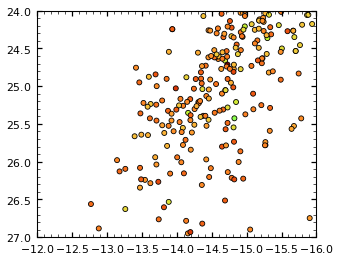

In [259]:
sct = plt.scatter(udg_cat['V_abs'], 
                  udg_cat['SB_0'][:, 0], 
            c=gi_color,
            label='UDGs')

plt.ylim(27, 24)
plt.xlim(-12, -16)

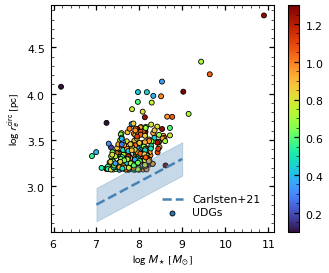

In [264]:
sct = plt.scatter(udg_cat['log_m_star'], 
            np.log10(udg_cat['rhalf_circularized_phys']) + 3, 
            c=gi_color, vmin=0.1, vmax=1.3,
            label='UDGs')

plt.colorbar()

x = np.linspace(7, 9)
plt.fill_between(x, mass_size_carlsten(x) - 0.181, 
                 mass_size_carlsten(x) + 0.181, 
                 color='steelblue', alpha=0.3)
plt.plot(x, mass_size_carlsten(x), ls='--', 
         color='steelblue', lw=3, label='Carlsten+21')

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'$\log\ r_{e}^{\rm circ}\ [\rm pc]$')
plt.legend(loc='lower right')

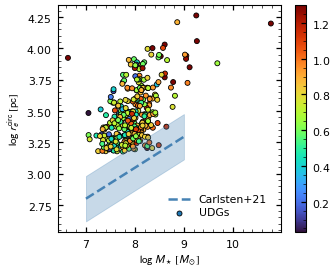

In [161]:
# old
sct = plt.scatter(udg_cat['log_m_star'], 
            np.log10(udg_cat['rhalf_circularized_phys']) + 3, 
            c=gi_color, vmax=1.3,
            label='UDGs')

plt.colorbar()

x = np.linspace(7, 9)
plt.fill_between(x, mass_size_carlsten(x) - 0.181, 
                 mass_size_carlsten(x) + 0.181, 
                 color='steelblue', alpha=0.3)
plt.plot(x, mass_size_carlsten(x), ls='--', 
         color='steelblue', lw=3, label='Carlsten+21')

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'$\log\ r_{e}^{\rm circ}\ [\rm pc]$')
plt.legend(loc='lower right')

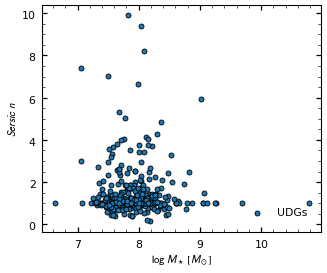

In [162]:
# old
sct = plt.scatter(udg_cat['log_m_star'], 
            udg_cat['sersic_n'], 
            label='UDGs')

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'$Sersic\ n$')
plt.legend(loc='lower right')

In [266]:
from scipy.stats import binned_statistic

In [267]:
quench_frac, bin_edges, _ = binned_statistic(udg_cat['log_m_star'], (gi_color > 0.8), 
                                             statistic='mean', range=(7, 9), bins=8)
num, bin_edges, _ = binned_statistic(udg_cat['log_m_star'], (gi_color > 0.8), 
                                             statistic='count', range=(7, 9), bins=8)

Text(0, 0.5, 'Quenched Fraction ($g - i > 0.8$)')

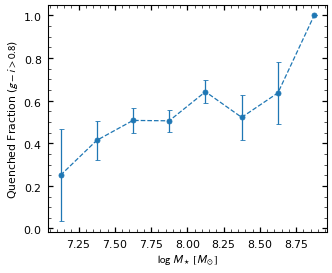

In [268]:
plt.errorbar((bin_edges[:-1] + bin_edges[1:]) / 2, 
             quench_frac, yerr=np.sqrt(quench_frac * (1 - quench_frac) / num), fmt='o--')
plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction ($g - i > 0.8$)')

In [ ]:
projected radius
red near contamination


Text(0, 0.5, 'Quenched Fraction ($g - i > 0.8$)')

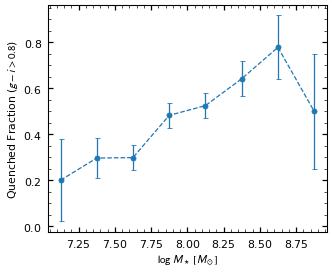

In [164]:
#old
plt.errorbar((bin_edges[:-1] + bin_edges[1:]) / 2, 
             quench_frac, yerr=np.sqrt(quench_frac * (1 - quench_frac) / num), fmt='o--')
plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction ($g - i > 0.8$)')

In [101]:
quench_frac, bin_edges, _ = binned_statistic(udg_cat['host_stellar_mass'], (gi_color > 0.8), 
                                             statistic='mean', range=(10.2, 11.2), bins=8)
num, bin_edges, _ = binned_statistic(udg_cat['host_stellar_mass'], (gi_color > 0.8), 
                                             statistic='count', range=(10.2, 11.2), bins=8)

Text(0, 0.5, 'Quenched Fraction ($g - i > 0.8$)')

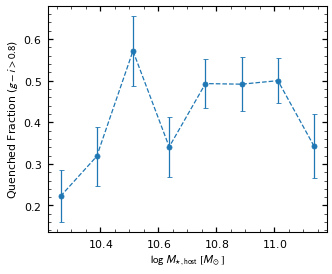

In [102]:
plt.errorbar((bin_edges[:-1] + bin_edges[1:]) / 2, 
             quench_frac, yerr=np.sqrt(quench_frac * (1 - quench_frac) / num), fmt='o--')
plt.xlabel(r'$\log\ M_{\star, \rm host}\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction ($g - i > 0.8$)')

In [103]:
quench_frac, bin_edges, _ = binned_statistic(udg_cat['host_halo_mass'], (gi_color > 0.8), 
                                             statistic='mean', range=(11.7, 13.5), bins=8)
num, bin_edges, _ = binned_statistic(udg_cat['host_halo_mass'], (gi_color > 0.8), 
                                             statistic='count', range=(11.7, 13.5), bins=8)

Text(0, 0.5, 'Quenched Fraction ($g - i > 0.8$)')

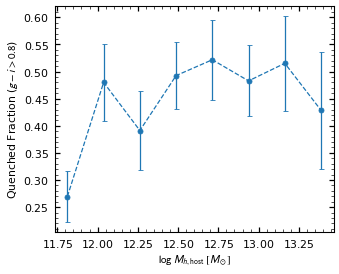

In [104]:
plt.errorbar((bin_edges[:-1] + bin_edges[1:]) / 2, 
             quench_frac, yerr=np.sqrt(quench_frac * (1 - quench_frac) / num), fmt='o--')
plt.xlabel(r'$\log\ M_{h, \rm host}\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction ($g - i > 0.8$)')

In [266]:
yagi_cat = Table.read('./Catalog/Yagi+16.fits')

In [221]:
flag = (yagi_cat['Re1'].data.data > 1.5)# & (yagi_cat['SuBr0'].data.data > 24.5)
yagi_cat = yagi_cat[flag]

In [222]:
yagi_cat['log_m_star'] = (4.83 - yagi_cat['Rmag1'] + 35.05) / (2.5)

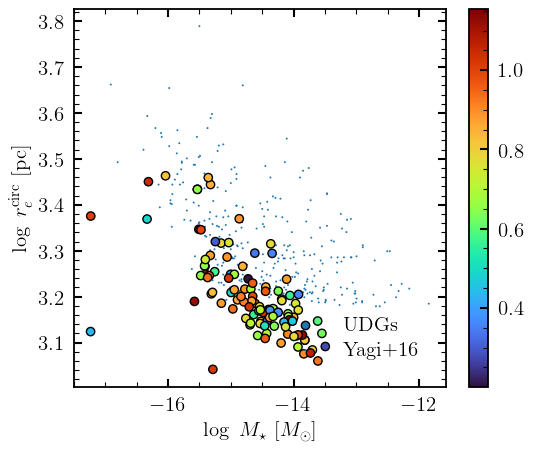

In [223]:
sct = plt.scatter(udg_cat['abs_mag'][:, 1], 
            np.log10(udg_cat['rhalf_circ_phys']) + 3, 
            c=gi_color,
            label='UDGs')
plt.colorbar()

#x = np.linspace(7, 9)
# plt.fill_between(x, mass_size_carlsten(x) - 0.181, 
#                  mass_size_carlsten(x) + 0.181, 
#                  color='steelblue', alpha=0.3)
# plt.plot(x, mass_size_carlsten(x), ls='--', 
#          color='steelblue', lw=3, label='Carlsten+21')


plt.scatter(yagi_cat['Rmag1'] - 35.05, np.log10(yagi_cat['Re1']) + 3, 
            label='Yagi+16', edgecolor='none', s=2, zorder=0)

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'$\log\ r_{e}^{\rm circ}\ [\rm pc]$')
plt.legend(loc='lower right')

In [226]:
yagi_cat = Table.read('./Catalog/Yagi+16.fits')

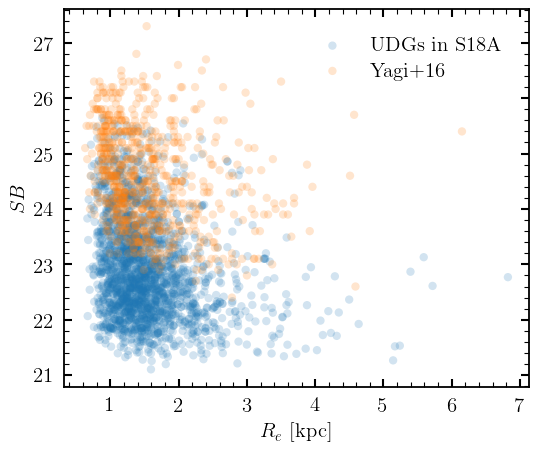

In [227]:
plt.scatter(cuts_cat['rhalf_circ_phys'], cuts_cat['SB_0'][:, 1], label='UDGs in S18A', alpha=0.2, edgecolor='none')
plt.scatter(yagi_cat['Re1'], yagi_cat['SuBr0'], label='Yagi+16', alpha=0.2, edgecolor='none')
#plt.scatter(cuts_cat['log_m_star'][flag], cuts_cat['rhalf_ellip_phys'][flag])


plt.xlabel(r'$R_e\ [\rm kpc]$')
plt.ylabel(r'$SB$')
plt.legend()